# The Traveling Salesman Problem

Given a complete weighted graph, what is the shortest path that visits each node exactly once before returning to the starting node?

This notebook contains implementations and brief explanations for different approaches to the Traveling Salesman Problem (TSP).

Each function outputs the length of the found path and a list containing the order to visit the nodes in. Note that some versions of the TSP only ask for the length of the path, and those functions would be slightly faster than these implementations.

### Representing a Graph

Just as our BFS and DFS algorithms used an adjacency list dictionary, we're going to want a data structure that represents the graphs that we give to our functions.

We will use an **adjacency matrix**, which is a 2D array containing info about each connection in the graph.

For a graph c, `c[i][j]` = Distance from node i to node j

Consider this graph:

![graph 1](graph1.png)

Its corresponding adjacency matrix would be:
```python
[[float('inf'), 20, 30, 10, 11],
 [15, float('inf'), 16, 4, 2],
 [3, 5, float('inf'), 2, 4],
 [19, 6, 18, float('inf'), 3],
 [16, 4, 7, 16, float('inf')]]
```

It doesn't matter what values we put in the `[i][i]` spots, since we won't ever travel to a node from itself. Making them `float(inf)` will be helpful in one of the algorithms.

Here's a function that generates a random graph as an adjacency matrix:

In [3]:
import random

def create_random_tsp(n, min_length=1, max_length=100):
    """
    Creates an adjacency matrix graph.
    
    Parameters
    ----------
    n: int
        The number of nodes in the graph.
    min_length: int
        The minimum edge length. Defaults to 1.
    max_length: int
        The maximum edge length. Defaults to 100.
        
    Returns
    -------
    [[int]]
        An adjacency matrix adhering to the specified parameters.
    """
    problem = [[random.randint(min_length, max_length) for i in range(n)] for j in range(n)]
    for i in range(n):
        problem[i][i] = float('inf')
    return problem

In [8]:
random_tsp = create_random_tsp(5)
random_tsp

[[inf, 58, 29, 95, 72],
 [11, inf, 13, 85, 82],
 [72, 28, inf, 51, 45],
 [15, 9, 76, inf, 30],
 [19, 74, 92, 81, inf]]

This function generates **asymmetric** graphs, meaning that `G[i][j]` doesn't necessarily equal `G[j][i]`. Symmetric graphs are a more specific case of the TSP, and as such can be represented in the same way.

To denote the absence of an edge, you can set its value in the graph to `float(inf)`. If one of the algorithms returns a length of infinity, that means there's no possible TSP solution.

If you'd like a visual representation of a graph, here's a function that takes an adjacency_matrix and plots the graph, although be aware that labels will overlap for larger graphs:

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_matrix(adjacency_matrix, bidirectional=True, labels=True):
    """
    Displays an adjacency matrix as a node-edge graph.
    
    Parameters
    ----------
    adjacency_matrix: [[int]]
        A graph as an adjacency matrix.
    bidirectional: bool
        Whether to draw as asymmetric (true) or symmetric (false). Defaults to True.
    labels: bool
        Whether to include edge length labels. Defaults to true.
    """
    G = nx.DiGraph()
    edges = []
    for i, row in enumerate(adjacency_matrix):
        for j, element, in enumerate(row):
            if i != j:
                edges.append((i, j, element))
    G.add_weighted_edges_from(edges)
    layout = nx.circular_layout(G)
    if bidirectional:
        nx.draw(G, layout, with_labels=True, node_size=1250, connectionstyle='arc3, rad = 0.05')
        if labels:
            edge_labels = {(u, v): f'{G.edges[(v, u)]["weight"]}\n\n{d["weight"]}' 
                           for u, v, d in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, layout, edge_labels=edge_labels, font_size=8)
    else:
        nx.draw(G, layout, with_labels=True)
        if labels:
            nx.draw_networkx_edge_labels(G, layout, edge_labels=nx.get_edge_attributes(G, 'weight'))

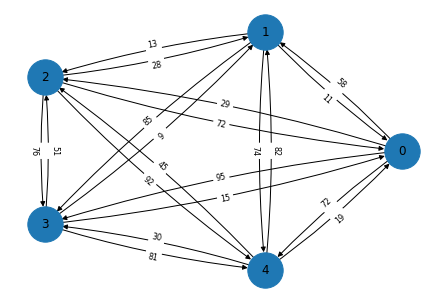

In [9]:
graph_matrix(random_tsp)

## The Brute Force Approach

The most straightforward approach to the TSP is to try every possible path and take the minimum. For a graph of size n=5, this would result in us testing:
- 0-1-2-3-4-0
- 0-1-2-4-3-0
- 0-1-3-2-4-0
- 0-1-3-4-2-0
- 0-1-4-2-3-0
- 0-1-4-3-2-0
- 0-2-1-3-4-0
- 0-2-1-4-3-0
- 0-2-3-1-4-0
- 0-2-3-4-1-0
- 0-2-4-1-3-0
- 0-2-4-3-1-0
- 0-3-1-2-4-0
- 0-3-1-4-2-0
- 0-3-2-1-4-0
- 0-3-2-4-1-0
- 0-3-4-1-2-0
- 0-3-4-2-1-0
- 0-4-1-2-3-0
- 0-4-1-3-2-0
- 0-4-2-1-3-0
- 0-4-2-3-1-0
- 0-4-3-1-2-0
- 0-4-3-2-1-0

which is 24, or (n-1)! possiblities. Thus, we get a runtime of $O(n!)$.

This method, while inefficient, is also relatively easy to implement recursively and will give us something to check our other methods against.

Starting with the origin, we'll call the function on each node left to explore, decreasing the set of remaining nodes accordingly until there are none left to visit, at which point we'll hit the base case and return a length and path that each get added to as we move back up the call stack. From each branch, we take the shortest path until we arrive back at the beginning.

In [12]:
def tsp_brute_force(adjacency_matrix, current_node = 0, remaining_nodes = None, origin = None):
    """
    Solves the Traveling Salesman Problem via brute force.
    
    Parameters
    ----------
    adjacency_matrix: [[int]]
        An adjacency matrix representing the graph to be searched.
    current_node: int
        The number of the node being examined. On external call, represents the starting node.
        Defaults to 0.
    remaining_nodes: {int}?
        Used in recursive calls only. Represents the nodes that haven't yet been visited.
    origin: int?
        Used in recursive calls only. Tracks the original starting node.
        
    Returns
    -------
    int
        The length of the shortest solution to the TSP.
    [int]
        The path solution to the TSP as a list of node names.
    """
    # happens on first call
    if remaining_nodes is None and origin is None:
        remaining_nodes = set(range(len(adjacency_matrix))) - {current_node}
        origin = current_node
    # base case
    if len(remaining_nodes) == 0:
        # nodes are appended to the path in reverse order before being reversed at the end
        return [adjacency_matrix[current_node][origin], [origin, current_node]]
    possible_paths = []
    # check all possible outgoing paths; track lengths
    for node in remaining_nodes:
        path_info = tsp_brute_force(adjacency_matrix, node, remaining_nodes - {node}, origin)
        path_info[0] += adjacency_matrix[current_node][node]
        possible_paths.append(path_info)
    # take shortest path
    best_path = min(possible_paths, key = lambda x: x[0])
    best_path[1].append(current_node)
    # cleans up input before final return
    if origin == current_node:
        best_path[1].reverse()
        best_path = tuple(best_path)
    return best_path

In [14]:
# example
G =  [
    [float('inf'), 20, 30, 10, 11],
    [15, float('inf'), 16, 4, 2],
    [3, 5, float('inf'), 2, 4],
    [19, 6, 18, float('inf'), 3],
    [16, 4, 7, 16, float('inf')]
]
tsp_brute_force(G)

(28, [0, 3, 1, 4, 2, 0])

## Optimizations

The following two approaches improve on the brute-force method, allowing for graphs of larger size to be solved, but they still scale extremely poorly as graph size increases and thus aren't true solutions to the problem.

### The Dynamic Programming Approach

Consider the following graph with size n=6 (and length labels omitted):

![graph 2](graph2.png)

During the brute force algorithm, the first path we try would start as 0-1-2-3.

From that point, there are two possibilities: 3-4-5-0 and 3-5-4-0.

We have no information about either path, so we'll follow each of them and calculate their lengths. Let's say we find that 3-5-4-0 is shorter.

Now, let's say that later on, a path we try starts as 0-2-1-3.

This would lead us to the *exact* same state as before, with 3-4-5-0 and 3-5-4-0 as the two remaining possibilities.

In a purely recursive implementation, we would again test 3-4-5-0 and 3-5-4-0, and we would rediscover that 3-5-4-0 is shorter.

Dynamic programming builds on the recursive method. The difference is that when we first calculate which of 3-4-5-0 and 3-5-4-0 is shorter, **we'll save the result so that we don't have to do it again**.

To do so, we'll pass a dictionary through each of our function calls that contains all the info about what we've explored so far. Each time we discover something new, we write to the dictionary. Using the example above, we'd write:
```python
saved_values[(3, 4, 5)] = [length, [0, 4, 5, 3]]
```
which means that for a starting node 3 and remaining nodes 4 and 5, the shortest path to the origin is 3-5-4-0 with length `length`. (The tour path is tracked in reverse order.)

Whenever we would make a recursive call, we'll first check the dictionary to see if we've already calculated the shortest path. If we have, we'll skip the call and use that value instead.

As the size of the graph gets larger, this optimization will save us from more and more recursive calls, thereby increasing the maximum size of a doable problem.

Its runtime is $O(2^n)$, which is definitely faster than brute force, but it still scales poorly and can't do large problems.

This idea is implemented below:

In [17]:
def tsp_dynamic(adjacency_matrix, current_node = 0, remaining_nodes = None, origin = None, saved_values = None):
    """
    Solves the Traveling Salesman Problem with dynamic programming.
    
    Parameters
    ----------
    adjacency_matrix: [[int]]
        An adjacency matrix representing the graph to be searched.
    current_node: int
        The number of the node being examined. On external call, represents the starting node.
        Defaults to 0.
    remaining_nodes: {int}?
        Used in recursive calls only. Represents the nodes that haven't yet been visited.
    origin: int?
        Used in recursive calls only. Tracks the original starting node.
    saved_values: dict?
        Used in recursive calls only. Tracks past results for dynamic programming.
        
    Returns
    -------
    int
        The length of the shortest solution to the TSP.
    [int]
        The path solution to the TSP as a list of node names.
    """
    # first call: set other parameters
    if remaining_nodes is None and origin is None and saved_values is None:
        remaining_nodes = set(range(len(adjacency_matrix))) - {current_node}
        origin = current_node
        saved_values = {}
    # base case
    if len(remaining_nodes) == 0:
        return [adjacency_matrix[current_node][origin], [origin, current_node]]
    possible_paths = []
    for node in remaining_nodes:
        # generate state-dependent key here
        # sorts remaining nodes so that sets are treated equally
        # also puts root node at front
        save_key = tuple([node] + sorted(list(remaining_nodes - {node})))
        # check if we've already gotten this key: if not, make recusive call and save result
        try:
            path_info = saved_values[save_key][:]
        except KeyError:
            path_info = tsp_dynamic(adjacency_matrix, node, remaining_nodes - {node}, origin, saved_values)
            saved_values[save_key] = path_info[:]
        path_info[0] += adjacency_matrix[current_node][node]
        possible_paths.append(path_info)
    # take shortest path
    best_path = min(possible_paths, key=lambda x: x[0])
    best_path[1] = best_path[1][:]
    best_path[1].append(current_node)
    # clean input before final return
    if origin == current_node:
        best_path[1].reverse()
        best_path = tuple(best_path)
    return best_path

In [18]:
# example
G =  [
    [float('inf'), 20, 30, 10, 11],
    [15, float('inf'), 16, 4, 2],
    [3, 5, float('inf'), 2, 4],
    [19, 6, 18, float('inf'), 3],
    [16, 4, 7, 16, float('inf')]
]
tsp_dynamic(G)

(28, [0, 3, 1, 4, 2, 0])

Try counting the number of times this function is called. How does this compare to the brute force algorithm?

### The Branch and Bound Approach

Branch and Bound allows us to do two important things:

1. Make better decisions about the order in which we evaluate nodes
2. See if we have the best solution without evaluating all possible paths

Let's use this adjacency matrix as an example (note that this is where the `float(inf)`s are helpful):

```
[[inf, 13, 18, 5], 
[10, inf, 24, 22], 
[25, 8, inf, 10], 
[8, 10, 18, inf]]
```

First, we are going to "reduce" the matrix. To do so, we subtract the smallest positive number in a row from each value in the row for each row, and do the same for columns.

For example, we would subtract 5 from each number in the first row, giving `[inf, 8, 13, 0]`.

After we go through every row and column, we'll have this "reduced" matrix:

```
[[inf, 8, 3, 0], 
[0, inf, 4, 12], 
[17, 0, inf, 2], 
[0, 2, 0, inf]]
```

and if we sum all the values we subtracted, we'll get 41.

This 41 represents a **lower bound** for the shortest path in the graph. We've effectively taken the minimum distance to exit each node (via the rows) and to arrive at each node (via the columns). 

Note that the best path is likely longer than 41, since the values we found might not satisfy the TSP conditions. For example, if both nodes 1 and 2 are closest to node 3, we can only choose one to visit.

Next, we'll generate all possible paths from the starting node and find their lower bounds. We take the reduced matrix from above and set certain values to infinity. For a starting node i, a branching node j, and an origin k:

- The ith row becomes infinity (we can't leave node i a second time)
- The jth column becomes infinity (we can't revisit node j)
- The kth element in the jth row becomes infinity (we can't go back to the origin unless all other nodes are visited, which we check for elsewhere)

We then reduce the resulting matrix and get its lower bound with the following formula:

$$bound_j = bound_{i} + distance_{ij} + reduction\_result$$

using the *reduced* matrix for node i to calculate distance.

We'll get this value for every node, store it, and **repeat the process for the node with the smallest lower bound**.

We don't throw away our past results, so each time we find the minimum value, we're looking at all nodes for which we've ever evaluated the lower bound, not just the ones we found in the most recent search.

We'll keep exploring nodes until we reach a leaf node (one that has no nodes left to visit besides the origin). This node will be our solution, and its bound will be the length of the path.

The branch and bound algorithm, as well as a matrix reduction function, are implemented below:

In [21]:
c =  [
    [float('inf'), 20, 30, 10, 11],
    [15, float('inf'), 16, 4, 2],
    [3, 5, float('inf'), 2, 4],
    [19, 6, 18, float('inf'), 3],
    [16, 4, 7, 16, float('inf')]
]

def reduce_matrix(matrix):
    """
    Subtracts values from an adjacency matrix such that each row and column has a zero.
    
    Parameters
    ----------
    matrix: [[int]]
        The adjacency matrix to reduce. Function directly edits the matrix.
    
    Returns
    -------
    int
        The total cost of reduction for the matrix.
    """
    # start with rows
    row_sum = 0
    for i in range(len(matrix)):
        min_in_row = min(matrix[i])
        # if all elements are infinity, the row counts as reduced
        if min_in_row == float('inf'):
            continue
        row_sum += min_in_row
        matrix[i] = [num - min_in_row for num in matrix[i]]
    # columns next
    column_sum = 0
    for i in range(len(matrix)):
        min_in_column = float('inf')
        for row in matrix:
            if row[i] < min_in_column:
                min_in_column = row[i]
        if min_in_column == float('inf'):
            continue
        column_sum += min_in_column
        new_matrix = []
        for row in matrix:
            row[i] -= min_in_column
            new_matrix.append(row)
        matrix = new_matrix
    return row_sum + column_sum

def tsp_bnb(adjacency_matrix, current_node = 0):
    """
    Solves the Traveling Salesman Problem with branch and bound.
    
    Parameters
    ----------
    adjacency_matrix: [[int]]
        An adjacency matrix representing the graph to be searched.
    current_node: int
        The number of the node being examined. On external call, represents the starting node.
        Defaults to 0.
        
    Returns
    -------
    int
        The length of the shortest solution to the TSP.
    [int]
        The path solution to the TSP as a list of node names.
    """
    matrix_copy = adjacency_matrix[:]
    # nodes tracked in format: (id, bound, matrix, remaining nodes, path)
    current_node = (current_node, 
                    reduce_matrix(matrix_copy), 
                    matrix_copy, 
                    set(range(len(matrix_copy))) - {current_node}, 
                    [current_node])
    origin = current_node
    nodes_to_examine = []
    # for this one, we use an iterative approach with a while condition as the "base case"
    while len(current_node[3]) > 0:
        for node in current_node[3]:
            new_matrix = [row[:] for row in current_node[2]]  # copy to prevent destroying original
            # set values to infinity
            new_matrix[current_node[0]] = [float('inf')] * len(new_matrix[0])
            for row in new_matrix:
                row[node] = float('inf')
            new_matrix[node][origin[0]] = float('inf')
            reduction_result = reduce_matrix(new_matrix)
            # bound of prev node + distance from prev to new + matrix reduction
            lower_bound = current_node[1] + current_node[2][current_node[0]][node] + reduction_result
            nodes_to_examine.append((node, lower_bound, new_matrix, current_node[3] - {node},
                                    current_node[4] + [node]))
        current_node = min(nodes_to_examine, key=lambda x: x[1])
        nodes_to_examine.remove(current_node)
    return (current_node[1], current_node[4] + [0])

In [23]:
G =  [
    [float('inf'), 20, 30, 10, 11],
    [15, float('inf'), 16, 4, 2],
    [3, 5, float('inf'), 2, 4],
    [19, 6, 18, float('inf'), 3],
    [16, 4, 7, 16, float('inf')]
]
tsp_bnb(G)

(28, [0, 3, 1, 4, 2, 0])

Although this method is generally faster than both the brute force and dynamic methods, its worst case time complexity is the same as brute force, since it's possible that we end up exploring every possible path.

## Approximations

The above solutions, while faster than brute force, still are slower than polynomial-time. Much like with the seating chart problem we did earlier in the year, instead of searching for the best solution, we can find a good solution in a much shorter amount of time.

### Nearest Neighbors

This greedy algorithm simply visits the nearest unvisited node each time. This results in a runtime of $O(n^2)$, which is significantly faster than the precise algorithms, and can be used to solve problems of a much larger size. However, its path is often suboptimal— there's even a possibility that it produces the worst possible tour.

In [31]:
def tsp_nn(adjacency_matrix, current_node = 0):
    """
    Approximates the Traveling Salesman Problem with branch and bound.
    
    Parameters
    ----------
    adjacency_matrix: [[int]]
        An adjacency matrix representing the graph to be searched.
    current_node: int
        The number of the node being examined. On external call, represents the starting node.
        Defaults to 0.
        
    Returns
    -------
    int
        The length of the shortest solution to the TSP.
    [int]
        The path solution to the TSP as a list of node names.
    """
    path = [current_node]
    # solution will have length len(matrix)-1
    for i in range(len(adjacency_matrix) - 1):
        # uses last element in path
        possible_nodes = adjacency_matrix[path[-1]][:]
        best_node = current_node
        # find minimum distance that isn't already in path
        while best_node in path:
            best_node = min(range(len(possible_nodes)), key=possible_nodes.__getitem__)
            # stop if we've gone through all possible nodes
            possible_nodes[best_node] = float('inf')
            done = True
            for node in possible_nodes:
                if node != float('inf'):
                    done = False
            if done:
                break
        path.append(best_node)
    # clean input, calculate distance from path list
    path.append(current_node)
    distance = 0
    for i in range(len(path) - 1):
        distance += adjacency_matrix[path[i]][path[i+1]]
    return (distance, path)



In [32]:
G =  [
    [float('inf'), 20, 30, 10, 11],
    [15, float('inf'), 16, 4, 2],
    [3, 5, float('inf'), 2, 4],
    [19, 6, 18, float('inf'), 3],
    [16, 4, 7, 16, float('inf')]
]

tsp_nn(G)

(36, [0, 3, 4, 1, 2, 0])

### Other Methods

There exist many other algorithms that approximate solutions to the TSP, almost all of which give better paths than the Nearest Neighbors approach. For example, the [Christofides–Serdyukov algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm) guarantees a solution with length within 1.5x of the optimal path. The methods that we looked at to improve the seating chart— hill climbing and genetic algorithms— can also be used to achieve a much closer solution to larger-sized problems.

## Time Comparison

In [15]:
import timeit
NUM_OF_PROBLEMS = 10
PROBLEM_SIZE = 11
functions = [tsp_brute_force, tsp_dynamic, tsp_bnb, tsp_nn]

problems = [create_random_tsp(PROBLEM_SIZE) for _ in range(NUM_OF_PROBLEMS)]
for function in functions:
    start_time = timeit.default_timer()
    print(f'{function.__name__}: ', end='')
    for problem in problems:
        function(problem)
    end_time = timeit.default_timer()
    print(f'\r{function.__name__}: {round(end_time - start_time, 4)}s')

tsp_brute_force: 168.3229s
tsp_dynamic: 0.8673s
tsp_bnb: 0.2245s
tsp_nn: 0.0023s


The brute force algorithm struggles to do problems of any greater size, but feel free to remove it from the `functions` list and adjust the other parameters. (Or test them individually with the `%%timeit` command at the top of a new cell.) What's the largest sized problem that each algorithm can handle?

In [28]:
%%timeit
tsp_dynamic(create_random_tsp(12))

131 ms ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
